In [7]:
import torch
import torch.nn.functional as F
import sys
try: # whether we're on titanic or not work on my regression_classif branch at least.
    sys.path.append("/home/mathieu/local/py_script/dnadna")
    import net as net_module
except ModuleNotFoundError:
    #sys.path.append("/home/jean/Documents/ML_genetics/dnadna/")
    #import net as net_module
    print("import fail")
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
dfparam = pd.read_csv('/media/mathieu/crucialmx300/exp/BacterialDemoSelection_param', sep="\t", header=0)
def compute_expected_class(scenario_name):
    expected_class = 1
    model_init = dfparam.at[int(scenario_name[9:]),'model_init']
    demo=""
    if 'Bottleneck' in model_init :
        expected_class = 0
        demo = "Bot"
    if 'Constant' in model_init :
        expected_class = 1
        demo="Cst"
    if 'Expansion' in model_init :
        expected_class = 2
        demo="Exp"
    selection = dfparam.at[int(scenario_name[9:]),'selection']
    return expected_class, demo, selection

In [9]:
#After gargammel result are in different repertories
#Repertories have different names depending which parameter have been used
#This function use the name of the repertorie to extract parameters value

def translate_real_param(dirname):
    realparam = dirname.replace('_', ' ').replace('t','-')
    params = realparam.split(',')
    coverage = params[0].split(' ')[1]
    if len(params) > 1:
        sequencing_error_param = params[1].split(' ')[1]
        sequencing_error = math.ceil(0.1 * 1/(pow(10,(int(sequencing_error_param)/10))))
    else:
        sequencing_error = 0.1
    return coverage, sequencing_error

In [10]:
#initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(3)
net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/media/mathieu/crucialmx300/skyline/BacterialDemoSelection_run_012_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)
#df = pd.read_csv("/home/mathieu/local/net/BacterialDemoSelection_008_preprocessed_param.csv", index_col=0)
#df.head()


In [11]:
originalDatapath="/media/mathieu/crucialmx300/exp/newresult/20"
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])

i=0
for scenario in os.listdir(originalDatapath):
    scenardir = originalDatapath +'/'+ scenario
    for replicate in os.listdir(scenardir):
        replicatepath = scenardir + '/' + replicate

        try :
            expected_class, demo, selection = compute_expected_class(scenario)
            
            #compute prediction
            data_snp = np.load(replicatepath)
            snp, pos = data_snp["SNP"], data_snp["POS"]
            matrixLength = snp.shape[1]
            data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

            output = net3(data_in)

            val, predicted_class = torch.max(output, 1)

            predicted_class_int = predicted_class.item()               
            softmax = sm(output)
            listsm = softmax.tolist()
            #softmax_float = max(listsm[0])

            #if predicted_class_int !=  expected_class :
             #   real_softmax_float = 1 - softmax_float
            #else :
             #   real_softmax_float = softmax_float

            #create new line for each replicate
            dfres.loc[i] = [scenario, replicate, 0, 0, 0, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
            i += 1

        except RuntimeError:
            #not enough positions ?
            print("error computing prediction for " + scenario + ':' + replicate + ': nbSNP=' + str(matrixLength))

dforiginal = dfres

error computing prediction for scenario_00032:BacterialDemoSelection_00032_012.npz: nbSNP=110
error computing prediction for scenario_00032:BacterialDemoSelection_00032_020.npz: nbSNP=72
error computing prediction for scenario_00032:BacterialDemoSelection_00032_026.npz: nbSNP=74
error computing prediction for scenario_00032:BacterialDemoSelection_00032_034.npz: nbSNP=56
error computing prediction for scenario_00032:BacterialDemoSelection_00032_035.npz: nbSNP=66
error computing prediction for scenario_00032:BacterialDemoSelection_00032_076.npz: nbSNP=55
error computing prediction for scenario_00919:BacterialDemoSelection_00919_009.npz: nbSNP=81
error computing prediction for scenario_00919:BacterialDemoSelection_00919_013.npz: nbSNP=85
error computing prediction for scenario_00919:BacterialDemoSelection_00919_024.npz: nbSNP=66
error computing prediction for scenario_00919:BacterialDemoSelection_00919_031.npz: nbSNP=26
error computing prediction for scenario_00919:BacterialDemoSelection_

error computing prediction for scenario_05859:BacterialDemoSelection_05859_085.npz: nbSNP=71
error computing prediction for scenario_05859:BacterialDemoSelection_05859_089.npz: nbSNP=53
error computing prediction for scenario_05887:BacterialDemoSelection_05887_000.npz: nbSNP=74
error computing prediction for scenario_05887:BacterialDemoSelection_05887_006.npz: nbSNP=87
error computing prediction for scenario_05887:BacterialDemoSelection_05887_007.npz: nbSNP=93
error computing prediction for scenario_05887:BacterialDemoSelection_05887_015.npz: nbSNP=109
error computing prediction for scenario_05887:BacterialDemoSelection_05887_018.npz: nbSNP=75
error computing prediction for scenario_05887:BacterialDemoSelection_05887_031.npz: nbSNP=102
error computing prediction for scenario_05887:BacterialDemoSelection_05887_033.npz: nbSNP=78
error computing prediction for scenario_05887:BacterialDemoSelection_05887_049.npz: nbSNP=93
error computing prediction for scenario_05887:BacterialDemoSelection

error computing prediction for scenario_02107:BacterialDemoSelection_02107_083.npz: nbSNP=43
error computing prediction for scenario_02107:BacterialDemoSelection_02107_098.npz: nbSNP=110
error computing prediction for scenario_02191:BacterialDemoSelection_02191_015.npz: nbSNP=81
error computing prediction for scenario_02191:BacterialDemoSelection_02191_047.npz: nbSNP=137
error computing prediction for scenario_02191:BacterialDemoSelection_02191_078.npz: nbSNP=60
error computing prediction for scenario_02191:BacterialDemoSelection_02191_079.npz: nbSNP=135
error computing prediction for scenario_02191:BacterialDemoSelection_02191_098.npz: nbSNP=82
error computing prediction for scenario_02576:BacterialDemoSelection_02576_004.npz: nbSNP=132
error computing prediction for scenario_02576:BacterialDemoSelection_02576_033.npz: nbSNP=90
error computing prediction for scenario_02576:BacterialDemoSelection_02576_055.npz: nbSNP=119
error computing prediction for scenario_02576:BacterialDemoSelect

error computing prediction for scenario_03047:BacterialDemoSelection_03047_087.npz: nbSNP=59
error computing prediction for scenario_03049:BacterialDemoSelection_03049_009.npz: nbSNP=120
error computing prediction for scenario_03049:BacterialDemoSelection_03049_013.npz: nbSNP=90
error computing prediction for scenario_03049:BacterialDemoSelection_03049_021.npz: nbSNP=133
error computing prediction for scenario_03049:BacterialDemoSelection_03049_030.npz: nbSNP=84
error computing prediction for scenario_03049:BacterialDemoSelection_03049_053.npz: nbSNP=97
error computing prediction for scenario_03049:BacterialDemoSelection_03049_055.npz: nbSNP=108
error computing prediction for scenario_03049:BacterialDemoSelection_03049_057.npz: nbSNP=88
error computing prediction for scenario_03049:BacterialDemoSelection_03049_083.npz: nbSNP=93
error computing prediction for scenario_03049:BacterialDemoSelection_03049_085.npz: nbSNP=117
error computing prediction for scenario_03175:BacterialDemoSelecti

error computing prediction for scenario_03815:BacterialDemoSelection_03815_086.npz: nbSNP=90
error computing prediction for scenario_03853:BacterialDemoSelection_03853_004.npz: nbSNP=70
error computing prediction for scenario_03853:BacterialDemoSelection_03853_013.npz: nbSNP=72
error computing prediction for scenario_03853:BacterialDemoSelection_03853_019.npz: nbSNP=93
error computing prediction for scenario_03853:BacterialDemoSelection_03853_056.npz: nbSNP=38
error computing prediction for scenario_03853:BacterialDemoSelection_03853_060.npz: nbSNP=71
error computing prediction for scenario_03853:BacterialDemoSelection_03853_061.npz: nbSNP=96
error computing prediction for scenario_03853:BacterialDemoSelection_03853_074.npz: nbSNP=87
error computing prediction for scenario_03853:BacterialDemoSelection_03853_075.npz: nbSNP=109
error computing prediction for scenario_03853:BacterialDemoSelection_03853_096.npz: nbSNP=65
error computing prediction for scenario_03853:BacterialDemoSelection_

error computing prediction for scenario_04721:BacterialDemoSelection_04721_098.npz: nbSNP=21
error computing prediction for scenario_04859:BacterialDemoSelection_04859_006.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_019.npz: nbSNP=42
error computing prediction for scenario_04859:BacterialDemoSelection_04859_020.npz: nbSNP=38
error computing prediction for scenario_04859:BacterialDemoSelection_04859_030.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_045.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_048.npz: nbSNP=44
error computing prediction for scenario_04859:BacterialDemoSelection_04859_075.npz: nbSNP=46
error computing prediction for scenario_04859:BacterialDemoSelection_04859_076.npz: nbSNP=38
error computing prediction for scenario_04859:BacterialDemoSelection_04859_080.npz: nbSNP=39
error computing prediction for scenario_04859:BacterialDemoSelection_0

error computing prediction for scenario_10099:BacterialDemoSelection_10099_089.npz: nbSNP=40
error computing prediction for scenario_10227:BacterialDemoSelection_10227_003.npz: nbSNP=71
error computing prediction for scenario_10227:BacterialDemoSelection_10227_007.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_013.npz: nbSNP=81
error computing prediction for scenario_10227:BacterialDemoSelection_10227_025.npz: nbSNP=60
error computing prediction for scenario_10227:BacterialDemoSelection_10227_039.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_042.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_062.npz: nbSNP=57
error computing prediction for scenario_10227:BacterialDemoSelection_10227_079.npz: nbSNP=92
error computing prediction for scenario_10227:BacterialDemoSelection_10227_098.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_1

In [52]:
postGargapath = "/media/mathieu/crucialmx300/exp/newresult/damage"
i=0
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])
for degree in os.listdir(postGargapath):
    degreepath = postGargapath + '/' + degree
    if os.path.isdir(degreepath) :
        for param in os.listdir(degreepath):
            coverage, sequencing_error = translate_real_param(param)
            parampath = degreepath + '/' + param        
            for scenario in os.listdir(parampath):
                scenariopath =  parampath +'/'+ scenario
                for replicate in os.listdir(scenariopath):
                    replicatepath = scenariopath + '/' + replicate

                    
                    try :
                        
                        expected_class, demo, selection = compute_expected_class(scenario)

                        #compute prediction
                        data_snp = np.load(replicatepath)
                        snp, pos = data_snp["SNP"], data_snp["POS"]
                        matrixLength = snp.shape[1]
                        data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                        output = net3(data_in)

                        val, predicted_class = torch.max(output, 1)

                        predicted_class_int = predicted_class.item()               
                        softmax = sm(output)
                        listsm = softmax.tolist()
                        #softmax_float = max(listsm[0])

                        #if predicted_class_int !=  expected_class :
                         #   real_softmax_float = 1 - softmax_float
                        #else :
                         #   real_softmax_float = softmax_float

                        #create new line for each replicate
                        dfres.loc[i] = [scenario, replicate[1:], degree, float(coverage), sequencing_error, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
                        i += 1
            
                    except RuntimeError:
                        #not enough positions ?
                        print("error computing prediction for " + degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error) + \
                              '% :' + scenario + ':' + replicate[1:])
                    except IndexError:
                        print(degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error)+ scenario + ':' + replicate[1:] + " was not found")



error computing prediction for med: c=4, Erate=1% :scenario_09013:BacterialDemoSelection_09013_033.npz


In [28]:
# TP / (TP + FN)
# Proportion of the simulations with "bottleneck" predicted as such
def recall_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.expected_class == 0))

def recall_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.expected_class == 1))
def recall_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.expected_class == 2))

In [54]:
# TP / (TP + FP)
# Proportion of the simulations predicted as "bottleneck" that are actually "bottleneck"
def precision_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.observed_class == 0))

def precision_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.observed_class == 1)) 
def precision_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.observed_class == 2))

In [65]:
df_rb = dforiginal.groupby(["selection"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'
df_recall_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_recall_tot_ori

selection    recall demo
0      False  0.905660  Bot
1       True  0.649485  Bot
0      False  0.000000  Cst
1       True  0.000000  Cst
0      False  0.530928  Exp
1       True  0.210826  Exp

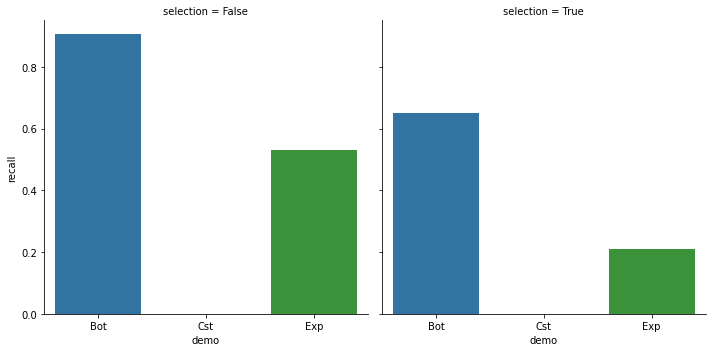

In [80]:
#original data recall
sns.catplot(data=df_recall_tot_ori, y="recall",x="demo", col="selection", kind="bar", legend_out=True)
plt.savefig('/home/mathieu/Bureau/fig/origrecall.png', transparent=False)

In [77]:
df_rb = dforiginal.groupby(["selection"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_precision_tot_ori

selection  precision demo
0      False   0.346154  Bot
1       True   0.234724  Bot
0      False   0.000000  Cst
1       True   0.000000  Cst
0      False   0.751825  Exp
1       True   0.305785  Exp

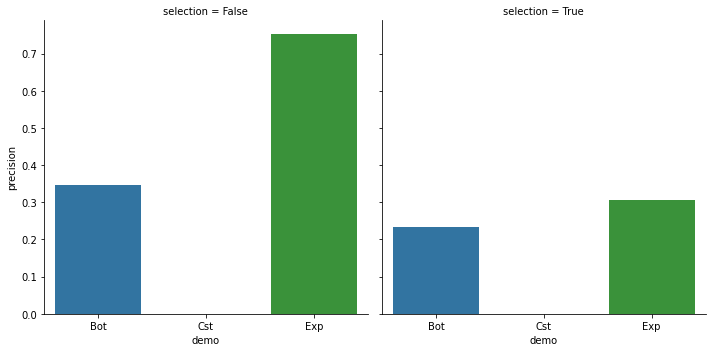

In [81]:
#original data precision
sns.catplot(data=df_precision_tot_ori, y="precision",x="demo", col="selection", kind="bar", legend_out=True)
plt.savefig('/home/mathieu/Bureau/fig/origprecis.png', transparent=False)